# Gas usage by component and opcode - exploratory analysis

#### Maria Silva, April 2025

## 1. Imports and settings

Let's start by importing the necessary libraries and setting up some directories and files.


In [1]:
import os
import sys
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

import warnings

warnings.filterwarnings("ignore")

In [2]:
# plotting theme
sns.set_theme(
    style="whitegrid", palette="Set2", rc={"figure.dpi": 500, "axes.titlesize": 15}
)

In [3]:
# Main directories and files
current_path = os.getcwd()
repo_dir = os.path.abspath(os.path.join(current_path, ".."))
src_dir = os.path.join(repo_dir, "src")
data_dir = os.path.join(repo_dir, "data")
op_files_dir = os.path.join(data_dir, "aggregated_opcodes_v3", "*", "file.parquet")

In [4]:
# import internal packages
sys.path.append(src_dir)
from data.gas_cost import compute_component_gas_costs_per_tx

## 2. Load data

Now, let's load the data. We will start by loading the opcodes used for blocks 22000000 to 22004000.

In [5]:
block_start = 22000000
block_end = 22004000
# Load parquet files with duckdb
query = f"""
SELECT *
FROM read_parquet(
    '{op_files_dir}', 
    hive_partitioning=True, 
    union_by_name=True
    )
WHERE block_height BETWEEN {block_start} AND {block_end};
"""
agg_trace_df = duckdb.connect().execute(query).fetchdf()
# Drop columns
agg_trace_df = agg_trace_df.drop(columns=["block_range"])
# Clean up repeated opcodes
agg_trace_df["op"] = np.where(
    agg_trace_df["op"].str.startswith("DUP"), "DUP", agg_trace_df["op"]
)
agg_trace_df["op"] = np.where(
    agg_trace_df["op"].str.startswith("SWAP"), "SWAP", agg_trace_df["op"]
)
agg_trace_df["op"] = np.where(
    (agg_trace_df["op"].str.startswith("PUSH")) & (agg_trace_df["op"] != "PUSH0"),
    "PUSH",
    agg_trace_df["op"],
)
# Compute total gas cost for opcode
agg_trace_df["op_total_gas_cost"] = (
    agg_trace_df["op_gas_cost"] * agg_trace_df["op_gas_pair_count"]
)
# Print info
agg_trace_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60809234 entries, 0 to 60809233
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   block_height       int64  
 1   tx_hash            object 
 2   op                 object 
 3   op_gas_cost        float64
 4   post_memory_size   int64  
 5   memory_expansion   int64  
 6   memory_size        int64  
 7   cum_refund         int64  
 8   call_address       object 
 9   op_gas_pair_count  int64  
 10  op_total_gas_cost  float64
dtypes: float64(2), int64(6), object(3)
memory usage: 5.0+ GB


In [6]:
agg_trace_df["block_height"].agg(["min", "max"])

min    22000000
max    22004000
Name: block_height, dtype: int64

Now, we can load the gas used per transaction.

In [7]:
# Load parquet file
tx_gas_info_df = pd.read_parquet(
    os.path.join(data_dir, "tx_gas_usage_22000000_22006000.parquet")
)
# Make sure we don't more blocks than agg_trace_df
tx_gas_info_df = tx_gas_info_df[
    tx_gas_info_df["block_height"].between(
        agg_trace_df["block_height"].min(), agg_trace_df["block_height"].max()
    )
]
# Print info
tx_gas_info_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 636134 entries, 0 to 636133
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   block_height            636134 non-null  int64 
 1   tx_hash                 636134 non-null  object
 2   tx_gas_cost             636134 non-null  int64 
 3   tx_gas_limit            636134 non-null  int64 
 4   tx_input_zero_bytes     636134 non-null  int64 
 5   tx_input_nonzero_bytes  636134 non-null  int64 
 6   tx_input_data_cost      636134 non-null  int64 
 7   is_contract_creation    636134 non-null  bool  
 8   is_success              636134 non-null  bool  
dtypes: bool(2), int64(6), object(1)
memory usage: 40.0+ MB


## 3. Process data

In [8]:
# Compute gas costs by component
comp_df = compute_component_gas_costs_per_tx(agg_trace_df, tx_gas_info_df)
comp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636134 entries, 0 to 636133
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   block_height           636134 non-null  int64  
 1   tx_hash                636134 non-null  object 
 2   total_gas_cost         636134 non-null  int64  
 3   input_data_cost        636134 non-null  int64  
 4   intrinsic_base_cost    636134 non-null  float64
 5   op_gas_cost            636134 non-null  float64
 6   gas_refund             636134 non-null  float64
 7   intrinsic_access_cost  636134 non-null  float64
dtypes: float64(4), int64(3), object(1)
memory usage: 38.8+ MB


In [9]:
strange_access_txs = comp_df[~comp_df["intrinsic_access_cost"].between(0, 4000000)][
    "tx_hash"
].values.tolist()
fail_txs = tx_gas_info_df[~tx_gas_info_df["is_success"]]["tx_hash"].values.tolist()
ignore_txs = fail_txs + strange_access_txs

In [10]:
filtered_comp_df = comp_df[~comp_df["tx_hash"].isin(ignore_txs)]

## 4. Gas usage by component

### Component total contribution

In [ ]:
melt_comp_df = filtered_comp_df.drop(columns=["total_gas_cost"])
melt_comp_df.columns = [
    "block_height",
    "tx_hash",
    "Input data",
    "Intrinsic base",
    "Opcode",
    "Refund",
    "Intrinsic access",
]
melt_comp_df = melt_comp_df.melt(
    id_vars=["block_height", "tx_hash"], var_name="component", value_name="cost"
)

compt_stats = melt_comp_df.groupby("component")["cost"].agg(
    ["sum", "mean", "std", "median"]
)
compt_stats

sum          mean            std   median
component                                                           
Input data        2.181508e+09   3491.479086   38411.983386    608.0
Intrinsic access  2.243141e+09   3590.123479   44173.321446      0.0
Intrinsic base    1.313795e+10  21027.144295     931.601860  21000.0
Opcode            5.764637e+10  92262.386260  652131.264276  24501.0
Refund            4.131863e+09   6613.002213   21494.320843      0.0

In [17]:
compt_stats["sum"] / filtered_comp_df["total_gas_cost"].sum()

component
Input data          0.030692
Intrinsic access    0.031559
Intrinsic base      0.184841
Opcode              0.811040
Refund              0.058132
Name: sum, dtype: float64

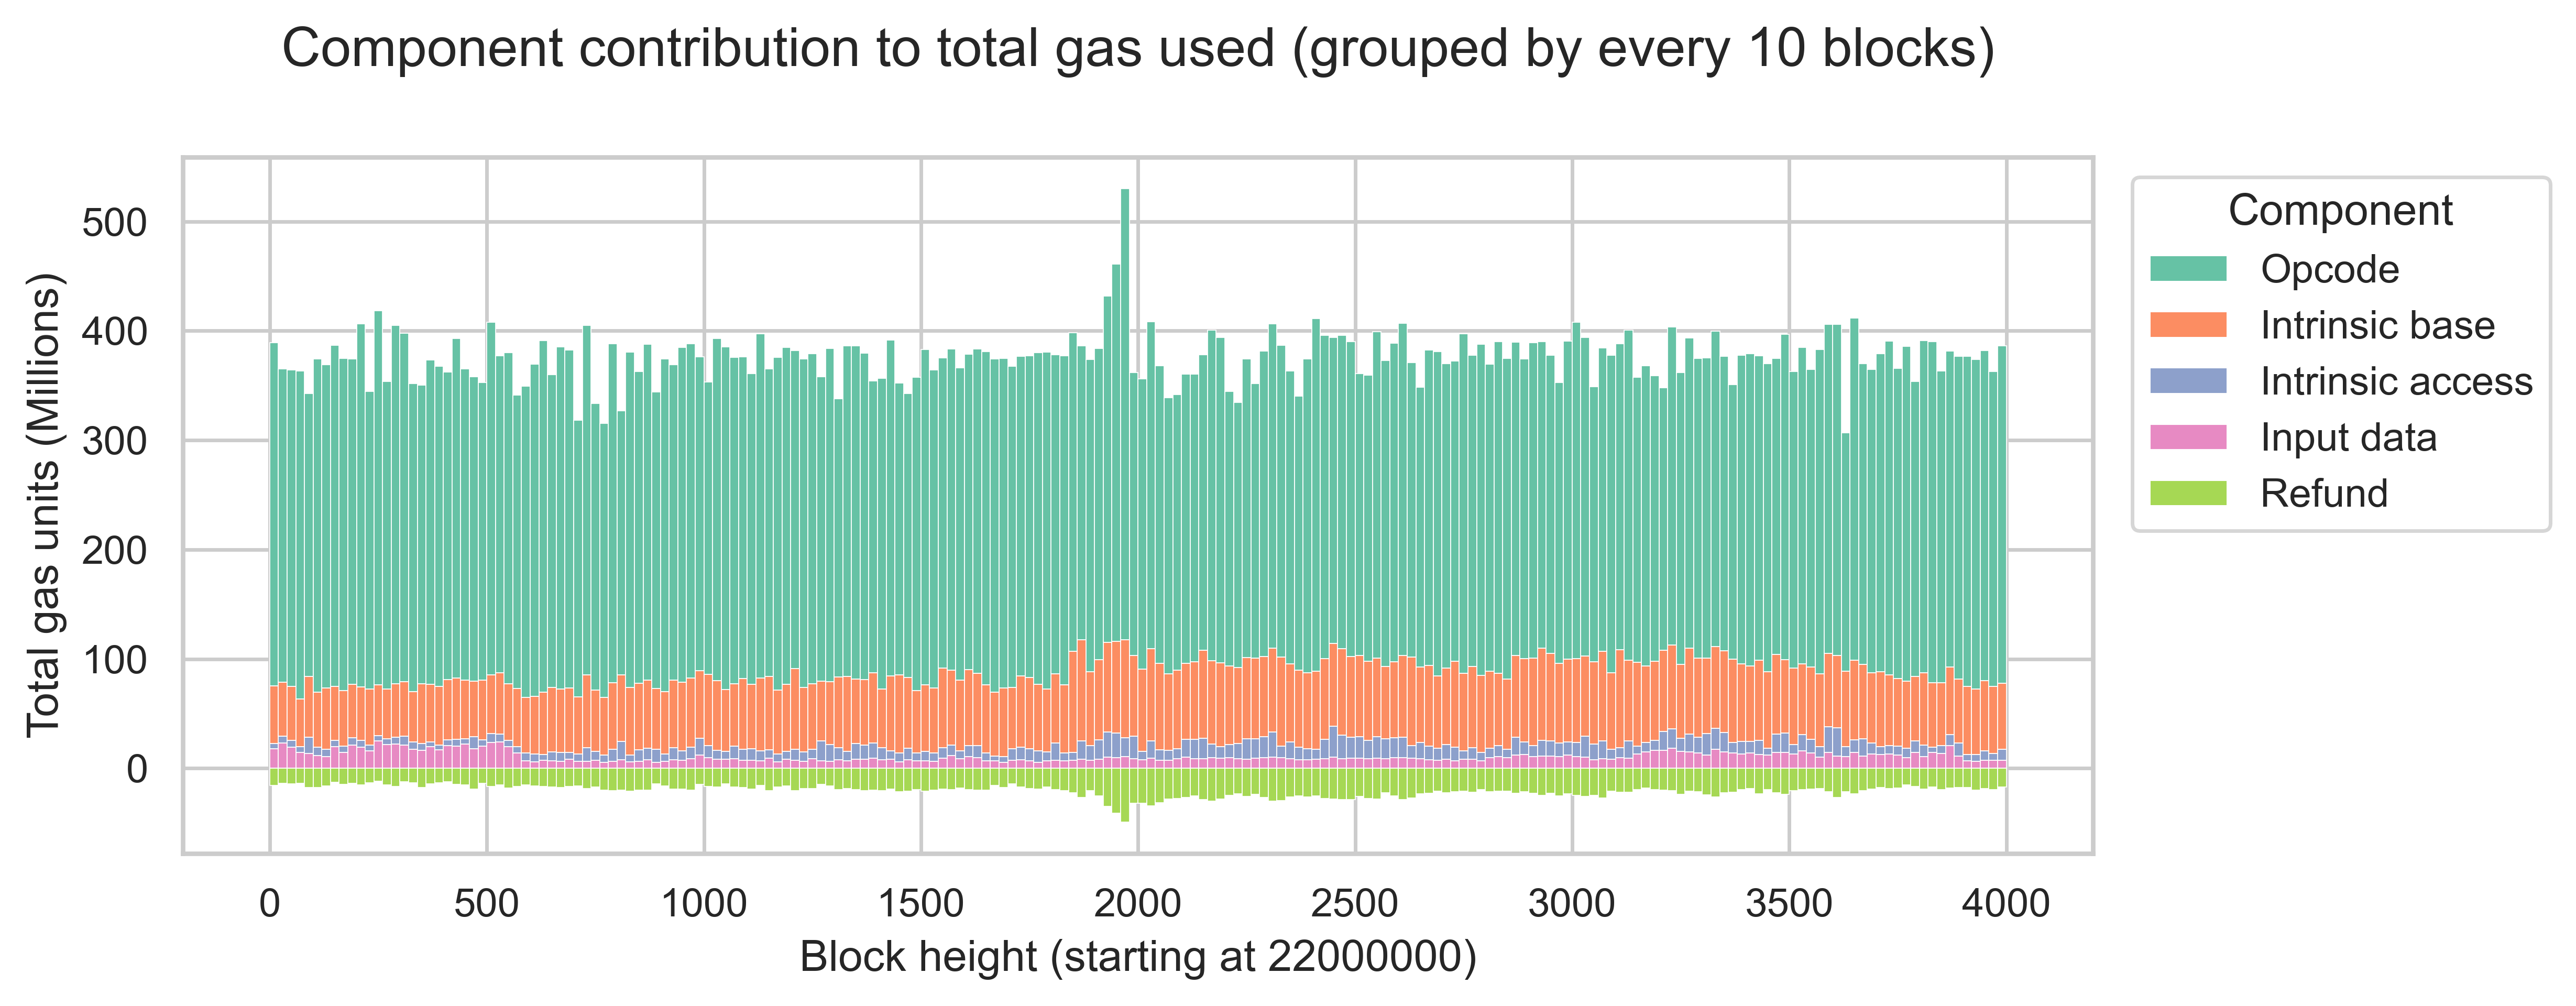

In [18]:
temp_df = melt_comp_df.groupby(["block_height", "component"])["cost"].sum() / 1_000_000
temp_df = temp_df.reset_index().sort_values("component", ascending=False)
temp_df["cost"] = np.where(
    temp_df["component"] == "Refund", -temp_df["cost"], temp_df["cost"]
)
temp_df["block_height"] = temp_df["block_height"] - 22000000

plt.figure(figsize=(10, 4))
ax1 = sns.histplot(
    temp_df[temp_df["component"] == "Refund"],
    x="block_height",
    weights="cost",
    color="#a6d854",
    bins=200,
    alpha=1.0,
)
ax2 = sns.histplot(
    temp_df[temp_df["component"] != "Refund"],
    x="block_height",
    weights="cost",
    hue="component",
    multiple="stack",
    bins=200,
    alpha=1.0,
)
legend_elements = [
    Rectangle((0, 0), 1, 1, facecolor="#66c2a5", label="Opcode"),
    Rectangle((0, 0), 1, 1, facecolor="#fc8d62", label="Intrinsic base"),
    Rectangle((0, 0), 1, 1, facecolor="#8da0cb", label="Intrinsic access"),
    Rectangle((0, 0), 1, 1, facecolor="#e78ac3", label="Input data"),
    Rectangle((0, 0), 1, 1, facecolor="#a6d854", label="Refund"),
]
ax1.legend(
    handles=legend_elements,
    bbox_to_anchor=(1.01, 1),
    loc="upper left",
    title="Component",
)
plt.title(
    "Component contribution to total gas used (grouped by every 10 blocks)", pad=25
)
plt.xlabel("Block height (starting at 22000000)")
plt.ylabel("Total gas units (Millions)")
plt.tight_layout()
plt.show()

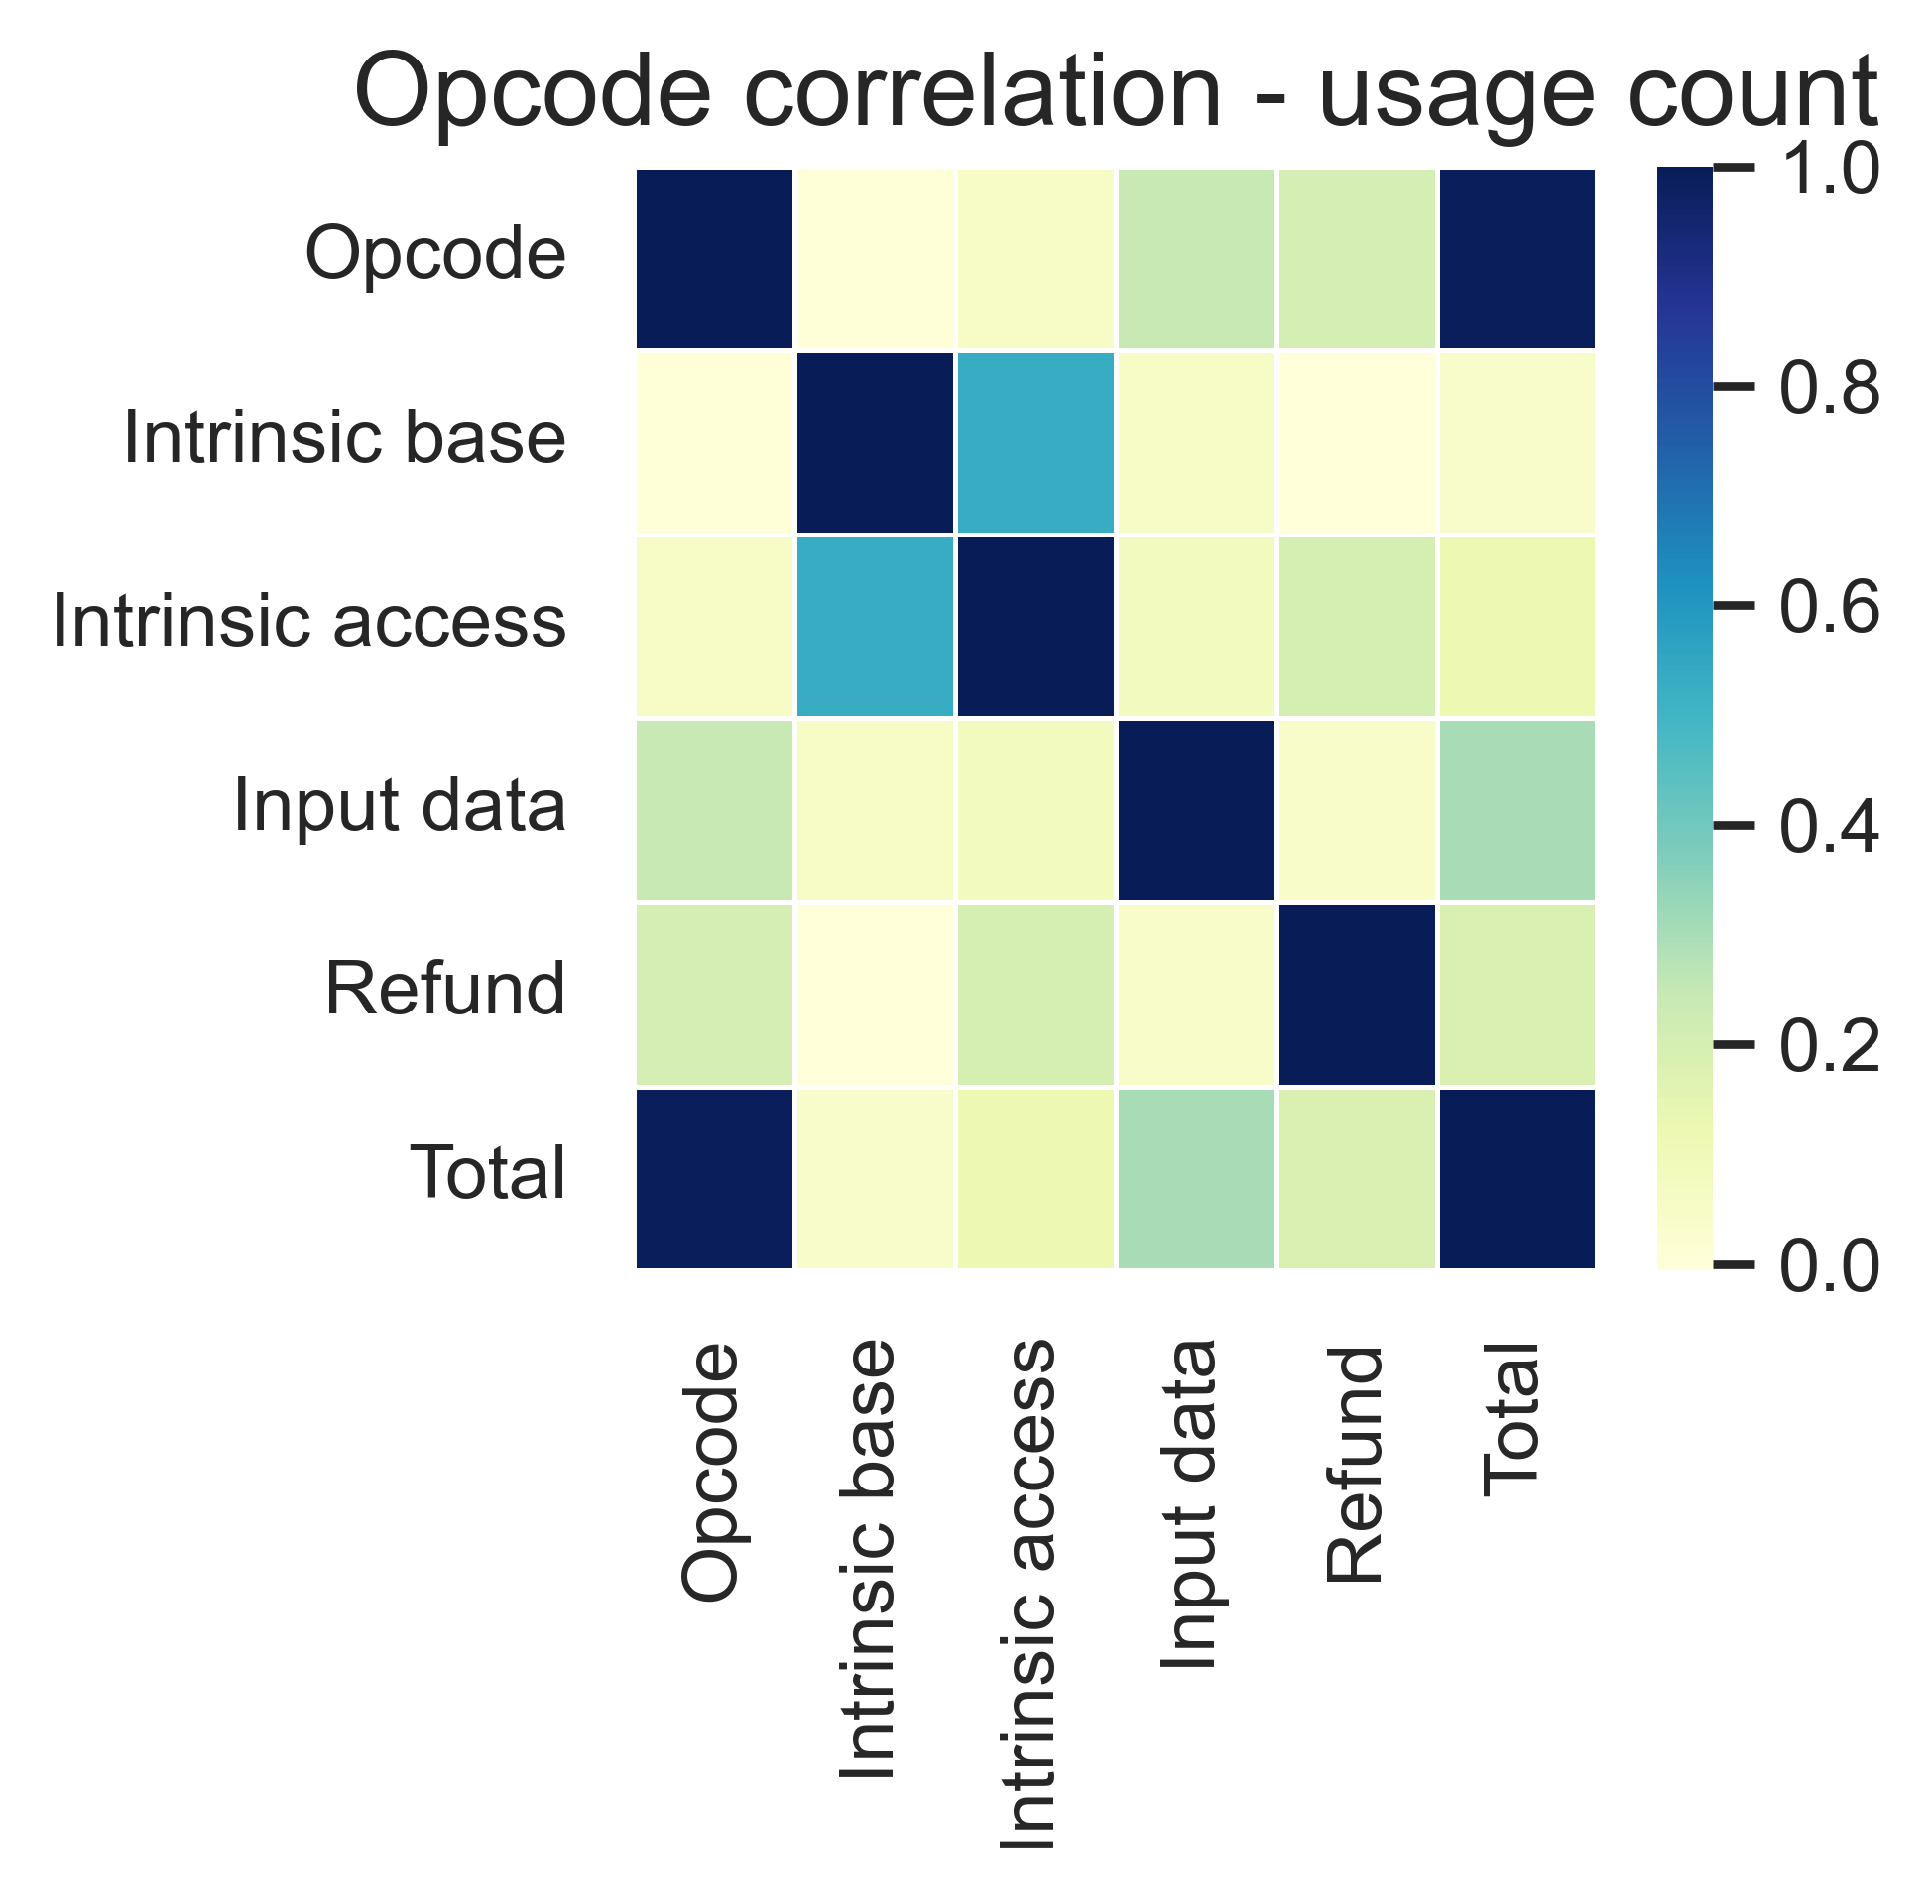

In [ ]:
temp_df = filtered_comp_df.drop(columns=["block_height"]).set_index("tx_hash")
temp_df.columns = [
    "Total",
    "Input data",
    "Intrinsic base",
    "Opcode",
    "Refund",
    "Intrinsic access",
]
temp_df = temp_df[
    ["Opcode", "Intrinsic base", "Intrinsic access", "Input data", "Refund", "Total"]
]
corr_mat = temp_df.corr()
plt.figure(figsize=(4, 4))
ax = sns.heatmap(corr_mat, cmap="YlGnBu", linewidths=0.5)
plt.title("Opcode correlation - usage count")
plt.tight_layout()
plt.show()

### Component percentage over transaction cost

In [29]:
melt_perc_comp_df = filtered_comp_df.drop(columns=["total_gas_cost"])
cols = [
    "Input data",
    "Intrinsic base",
    "Opcode",
    "Refund",
    "Intrinsic access",
]
melt_perc_comp_df.columns = ["block_height", "tx_hash"] + cols
melt_perc_comp_df[cols] = melt_perc_comp_df[cols].div(
    filtered_comp_df["total_gas_cost"], axis=0
)
melt_perc_comp_df = melt_perc_comp_df.melt(
    id_vars=["block_height", "tx_hash"], var_name="component", value_name="cost_perc"
)

melt_perc_comp_df.groupby("component")["cost_perc"].agg(["mean", "std", "median"])

mean       std    median
component                                     
Input data        0.015659  0.028954  0.010972
Intrinsic access  0.011255  0.057967  0.000000
Intrinsic base    0.557465  0.361234  0.465013
Opcode            0.457768  0.379870  0.532433
Refund            0.042147  0.072469  0.000000

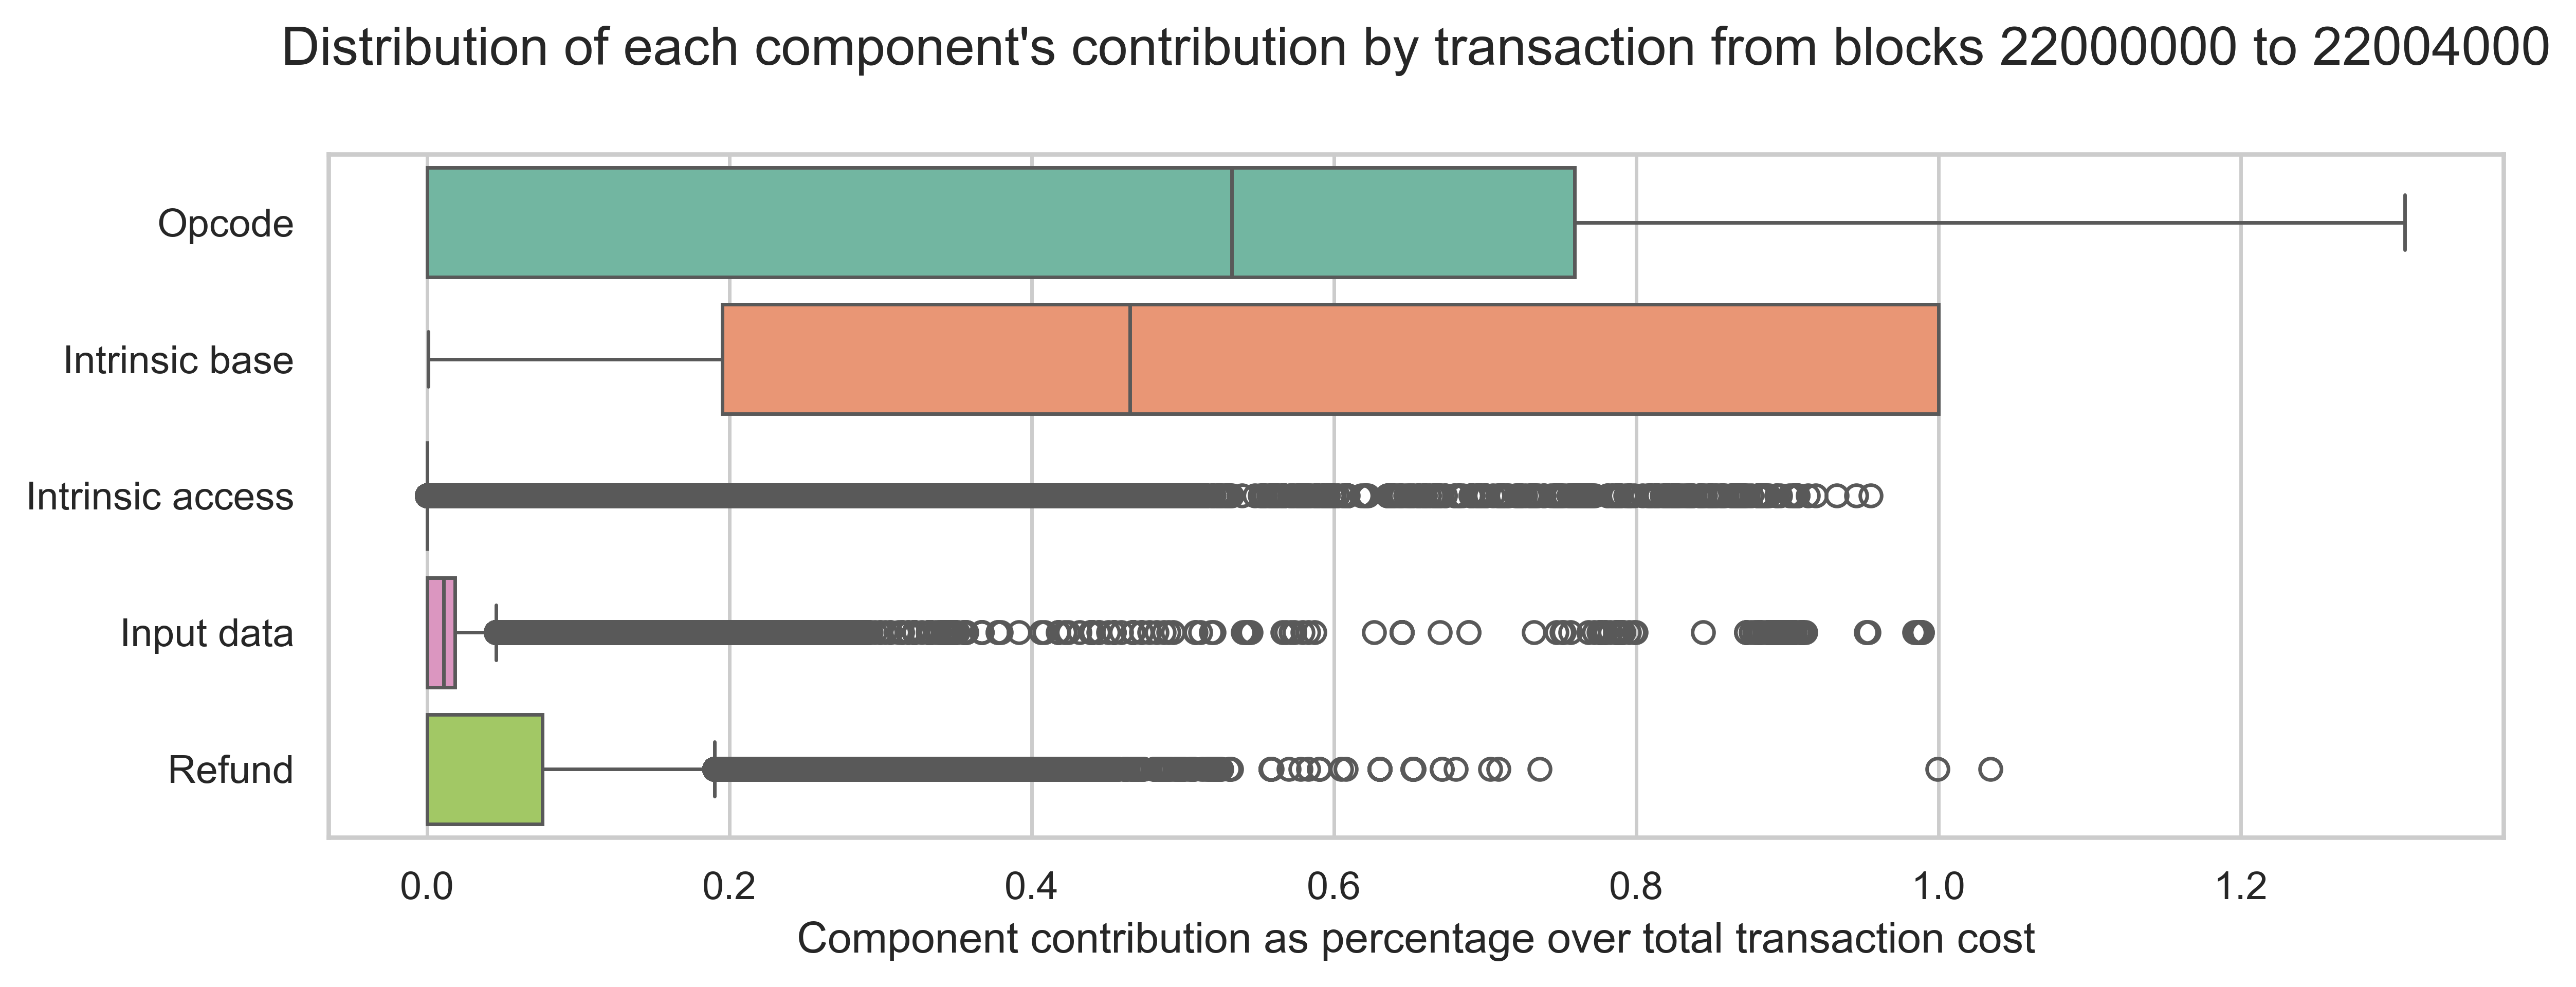

In [30]:
temp_df = melt_perc_comp_df[melt_perc_comp_df["component"] != "Refund"].sort_values(
    "component", ascending=False
)
temp_df = pd.concat(
    [temp_df, melt_perc_comp_df[melt_perc_comp_df["component"] == "Refund"]]
)
plt.figure(figsize=(10, 4))
sns.boxplot(
    y="component",
    x="cost_perc",
    data=temp_df,
    hue="component",
    legend=False,
)
plt.title(
    f"Distribution of each component's contribution by transaction from blocks {block_start} to {block_end}",
    pad=25,
)
plt.ylabel("")
plt.xlabel("Component contribution as percentage over total transaction cost")
plt.tight_layout()
plt.show()

#### Aditional examples and stats

In [32]:
filtered_comp_df.columns

Index(['block_height', 'tx_hash', 'total_gas_cost', 'input_data_cost',
       'intrinsic_base_cost', 'op_gas_cost', 'gas_refund',
       'intrinsic_access_cost'],
      dtype='object')

In [33]:
total_txs = len(filtered_comp_df)
print(
    np.round(
        len(filtered_comp_df[filtered_comp_df["op_gas_cost"] == 0.0]) / total_txs, 5
    ),
    "-- No opcode costs",
)
print(
    np.round(
        len(filtered_comp_df[filtered_comp_df["intrinsic_access_cost"] == 0.0]) / total_txs, 5
    ),
    "-- No intrinsic access costs",
)
print(
    np.round(
        len(filtered_comp_df[filtered_comp_df["gas_refund"] > 0.0]) / total_txs, 5
    ),
    "-- With refunds",
)
print(
    np.round(
        len(
            filtered_comp_df[
                filtered_comp_df["input_data_cost"]
                > 0.8 * filtered_comp_df["total_gas_cost"]
            ]
        )
        / total_txs,
        5,
    ),
    "-- High input data costs",
)
print(
    np.round(
        len(
            filtered_comp_df[
                filtered_comp_df["intrinsic_access_cost"]
                > 0.8 * filtered_comp_df["total_gas_cost"]
            ]
        )
        / total_txs,
        5,
    ),
    "-- High intrinsic access costs",
)
print(
    np.round(
        len(
            filtered_comp_df[
                filtered_comp_df["intrinsic_access_cost"]
                > 0.8 * filtered_comp_df["total_gas_cost"]
            ]
        )
        / len(filtered_comp_df[filtered_comp_df["intrinsic_access_cost"] != 0.0]),
        5,
    ),
    "-- High intrinsic access costs over txs with this cost component",
)
print(
    np.round(
        len(filtered_comp_df[filtered_comp_df["gas_refund"] > 0.0])
        / len(filtered_comp_df[filtered_comp_df["op_gas_cost"] > 0.0]),
        5,
    ),
    "-- Txs with refunds over txs with opcode costs",
)

0.35116 -- No opcode costs
0.90961 -- No intrinsic access costs
0.33873 -- With refunds
0.00019 -- High input data costs
0.00024 -- High intrinsic access costs
0.00269 -- High intrinsic access costs over txs with this cost component
0.52206 -- Txs with refunds over txs with opcode costs


In [36]:
filtered_comp_df[
    filtered_comp_df["input_data_cost"] > 0.8 * filtered_comp_df["total_gas_cost"]
]

block_height                                            tx_hash  \
6822        22001311  0x02b1069f617a0f7dc177448edff3c8c3a625452c6f09...   
8012        22003786  0x03333d3a9797c35055ab900e78215a7e9fe71cd64682...   
9385        22002990  0x03c1ea8423a3e93eaa109851dc7fea7f04cddd5dce69...   
10953       22002749  0x0463307f63767df1ebdce54add620ec50f10775e22e0...   
17837       22002908  0x0731b5855a3b4cb26a15d7d719ca84d88b025468fb87...   
...              ...                                                ...   
599459      22000114  0xf1313de5ca3b4c19036c4d8c68deab39da808e59ce8d...   
611655      22003983  0xf61db33c54c93548d69ca938d226aa5dd57fcf68b09b...   
617084      22001712  0xf852d1f4e0ee09982bfeee66b6e28de8c6b37d5722fa...   
625217      22002829  0xfb99d0c2b3a1a87604628f739d1fd1ef5dfcce122401...   
630783      22002471  0xfdccbc55f01be0427beee2c05d4245a24da59078e00f...   

        total_gas_cost  input_data_cost  intrinsic_base_cost  op_gas_cost  \
6822            208088           187088              21000.0          0.0   
8012            186400           165400              21000.0          0.0   
9385           1593328          1572328              21000.0          0.0   
10953           229300           208300              21000.0          0.0   
17837           191096           170096              21000.0          0.0   
...                ...              ...                  ...          ...   
599459          213440           192440              21000.0          0.0   
611655          178604           157604              21000.0          0.0   
617084          205264           184264              21000.0          0.0   
625217          190220           169220              21000.0          0.0   
630783          197696           176696              21000.0          0.0   

        gas_refund  intrinsic_access_cost  
6822           0.0                    0.0  
8012           0.0                    0.0  
9385           0.0                    0.0  
10953          0.0                    0.0  
17837          0.0                    0.0  
...            ...                    ...  
599459         0.0                    0.0  
611655         0.0                    0.0  
617084         0.0                    0.0  
625217         0.0                    0.0  
630783         0.0                    0.0  

[116 rows x 8 columns]

These transactions seem to be rollup submitting their data as call data instead of using blobs, reason why they are fairly rare.

In [37]:
filtered_comp_df[
    filtered_comp_df["intrinsic_access_cost"] > 0.8 * filtered_comp_df["total_gas_cost"]
]

block_height                                            tx_hash  \
343         22003161  0x002230e37a76d1f4d6d9493eb0bf6183048eb4641e82...   
2814        22003996  0x011b69121e43878db97bb6a091f4509070000dedcf21...   
5789        22001266  0x02449bd00379ef40b11e597d30e2112f2de26f426bdc...   
7737        22003490  0x03152c055a34ab69aae42bb238cd337bd052e2235682...   
12305       22001702  0x04eb44a91f3973e023d38080fbb67d5aa6c3fbccec2a...   
...              ...                                                ...   
628630      22003213  0xfcf86f9b4febd1a7582256126b4abacdc1daccefb644...   
629068      22001262  0xfd2396ba9fef34afa3bb0bb0061733d2a5c093c904d8...   
629932      22003274  0xfd7b86dfd98c2eb5a87d5db88688bfe577158a0353d1...   
630948      22002707  0xfddd640cb4d5f21ee135a64cbc3187d190d4d4a7796e...   
632049      22003023  0xfe51d795af52ff835085afb039877f4df89b1bc326d3...   

        total_gas_cost  input_data_cost  intrinsic_base_cost  op_gas_cost  \
343             923916            63388              53000.0      45664.0   
2814            844326            57728              53000.0        766.0   
5789           1205387            80916              53000.0       5535.0   
7737            831633            45092              53000.0      39099.0   
12305          3669103           263768              53000.0      27279.0   
...                ...              ...                  ...          ...   
628630          827761            56580              53000.0        753.0   
629068         1160204            79280              53000.0      23204.0   
629932         3271362           227760              53000.0      70068.0   
630948         1565626           107844              53000.0      45746.0   
632049         1396256           106636              53000.0      92776.0   

        gas_refund  intrinsic_access_cost  
343            0.0               761864.0  
2814           0.0               732832.0  
5789           0.0              1065936.0  
7737           0.0               694442.0  
12305          0.0              3325056.0  
...            ...                    ...  
628630         0.0               717428.0  
629068         0.0              1004720.0  
629932         0.0              2920534.0  
630948         0.0              1359036.0  
632049         0.0              1143844.0  

[152 rows x 8 columns]

## 5. Gas usage by opcode

In [38]:
filtered_usage_df = agg_trace_df[
    (~agg_trace_df["op"].isin(["NO_TRACE", "RESPONSE_TOO_LARGE"]))
    & (~agg_trace_df["tx_hash"].isin(ignore_txs))
]
filtered_usage_df["op"] = np.where(
    filtered_usage_df["op"].str.startswith("LOG"), "LOG", filtered_usage_df["op"]
)

In [39]:
filtered_usage_df["op"].nunique()

82

### Opcode usage counts

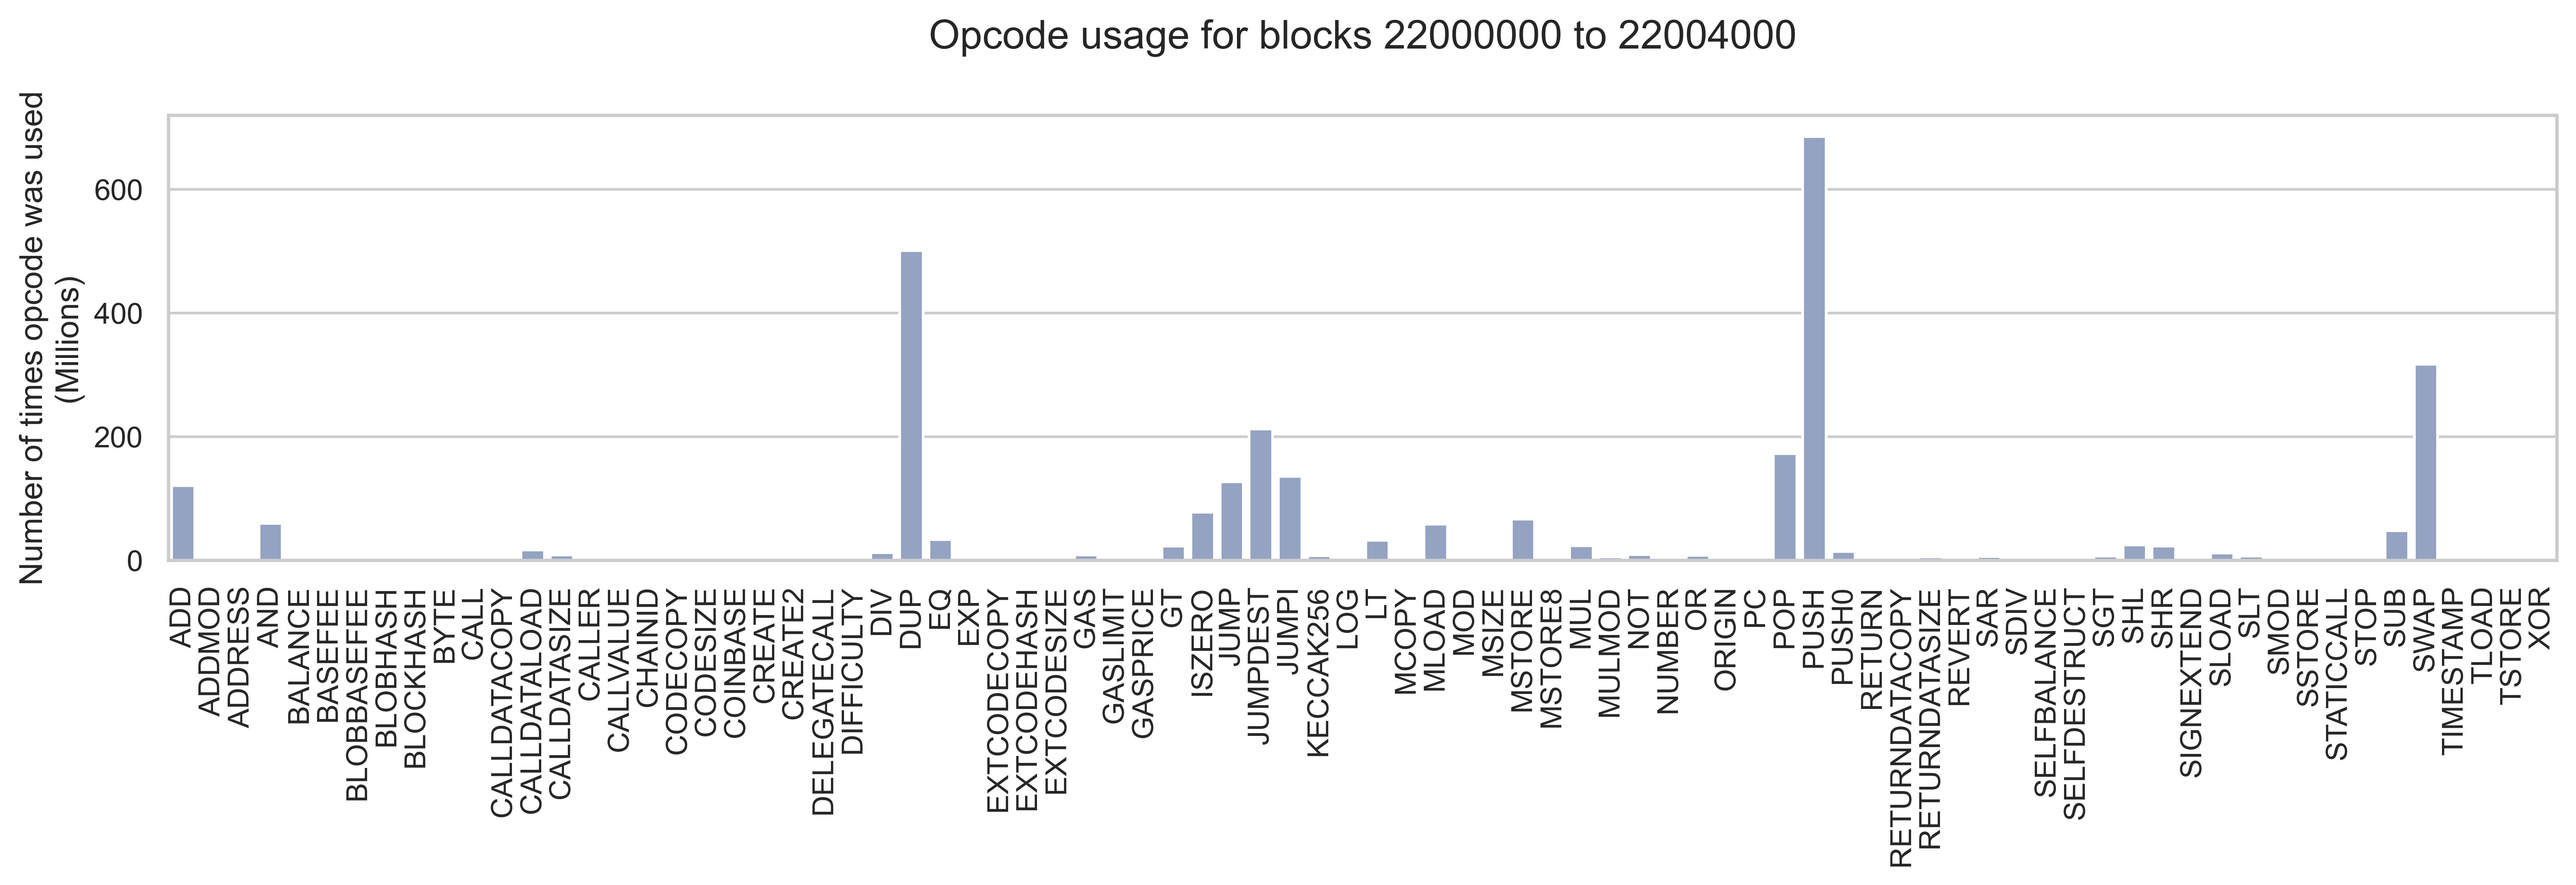

In [40]:
temp_df = filtered_usage_df.groupby("op")["op_gas_pair_count"].sum().reset_index()
temp_df["op_gas_pair_count"] = temp_df["op_gas_pair_count"] / 1_000_000
plt.figure(figsize=(16, 3))
sns.barplot(x="op", y="op_gas_pair_count", data=temp_df, color="#8da0cb")
plt.xticks(rotation=90)
plt.title(f"Opcode usage for blocks {block_start} to {block_end}", pad=25)
plt.ylabel("Number of times opcode was used\n(Millions)")
plt.xlabel("")
plt.show()

In [41]:
temp_df = (
    filtered_usage_df.groupby("op")["op_gas_pair_count"]
    .sum()
    .reset_index()
    .sort_values("op_gas_pair_count", ascending=False)
    .head(15)
)
temp_df["op_gas_pair_count_perc"] = temp_df["op_gas_pair_count"]/temp_df["op_gas_pair_count"].sum()
temp_df

op  op_gas_pair_count  op_gas_pair_count_perc
56      PUSH          685602591                0.258791
25       DUP          500990295                0.189106
77      SWAP          317088891                0.119690
37  JUMPDEST          212476690                0.080202
55       POP          172749949                0.065207
38     JUMPI          135626789                0.051194
36      JUMP          127126853                0.047986
0        ADD          120580361                0.045515
35    ISZERO           77987523                0.029438
46    MSTORE           66834815                0.025228
3        AND           59772745                0.022562
43     MLOAD           58173187                0.021958
76       SUB           48078541                0.018148
26        EQ           33763784                0.012745
41        LT           32400969                0.012230

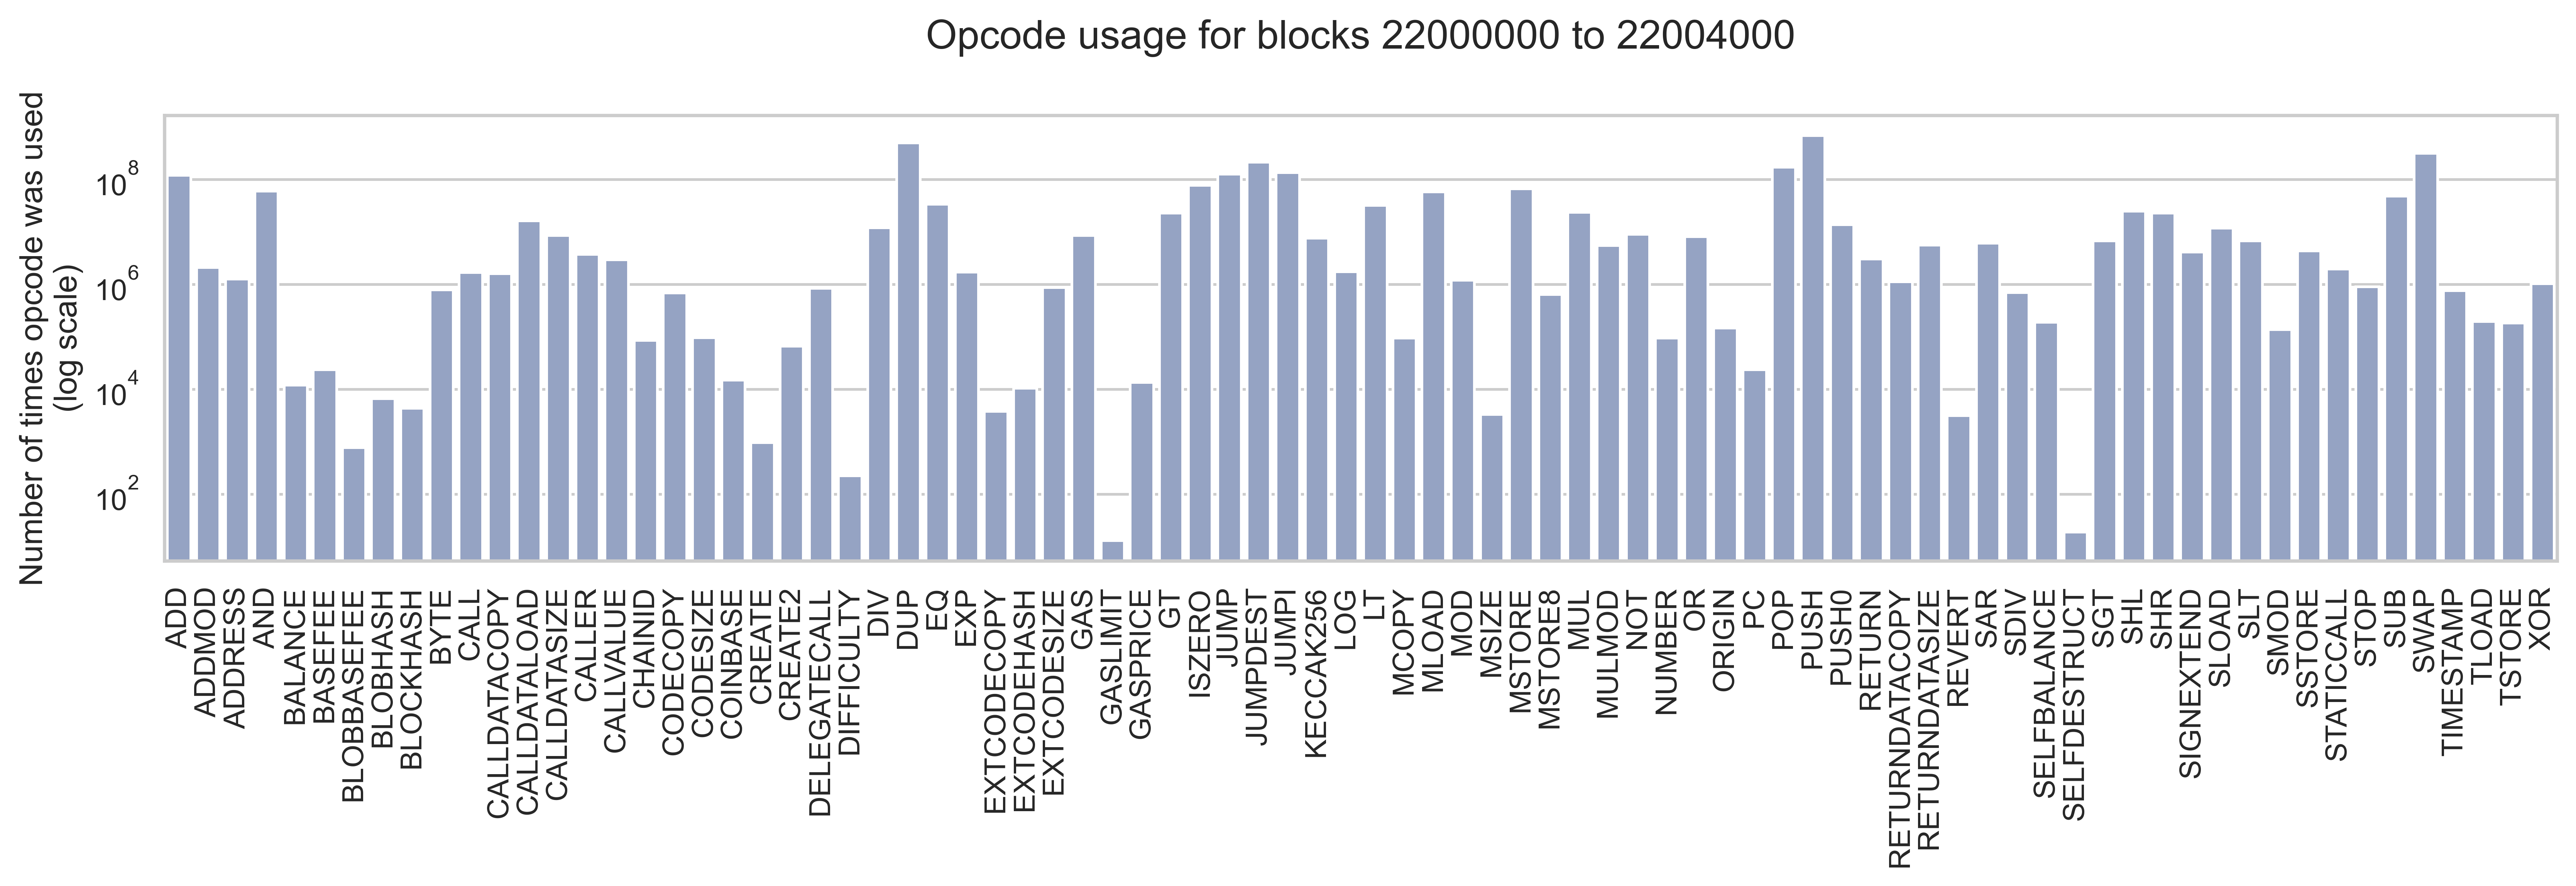

In [42]:
temp_df = filtered_usage_df.groupby("op")["op_gas_pair_count"].sum().reset_index()
temp_df["op_gas_pair_count"] = temp_df["op_gas_pair_count"]
plt.figure(figsize=(16, 3))
sns.barplot(x="op", y="op_gas_pair_count", data=temp_df, color="#8da0cb")
plt.xticks(rotation=90)
plt.yscale("log")
plt.title(f"Opcode usage for blocks {block_start} to {block_end}", pad=25)
plt.ylabel("Number of times opcode was used\n(log scale)")
plt.xlabel("")
plt.show()

### Opcode gas usage

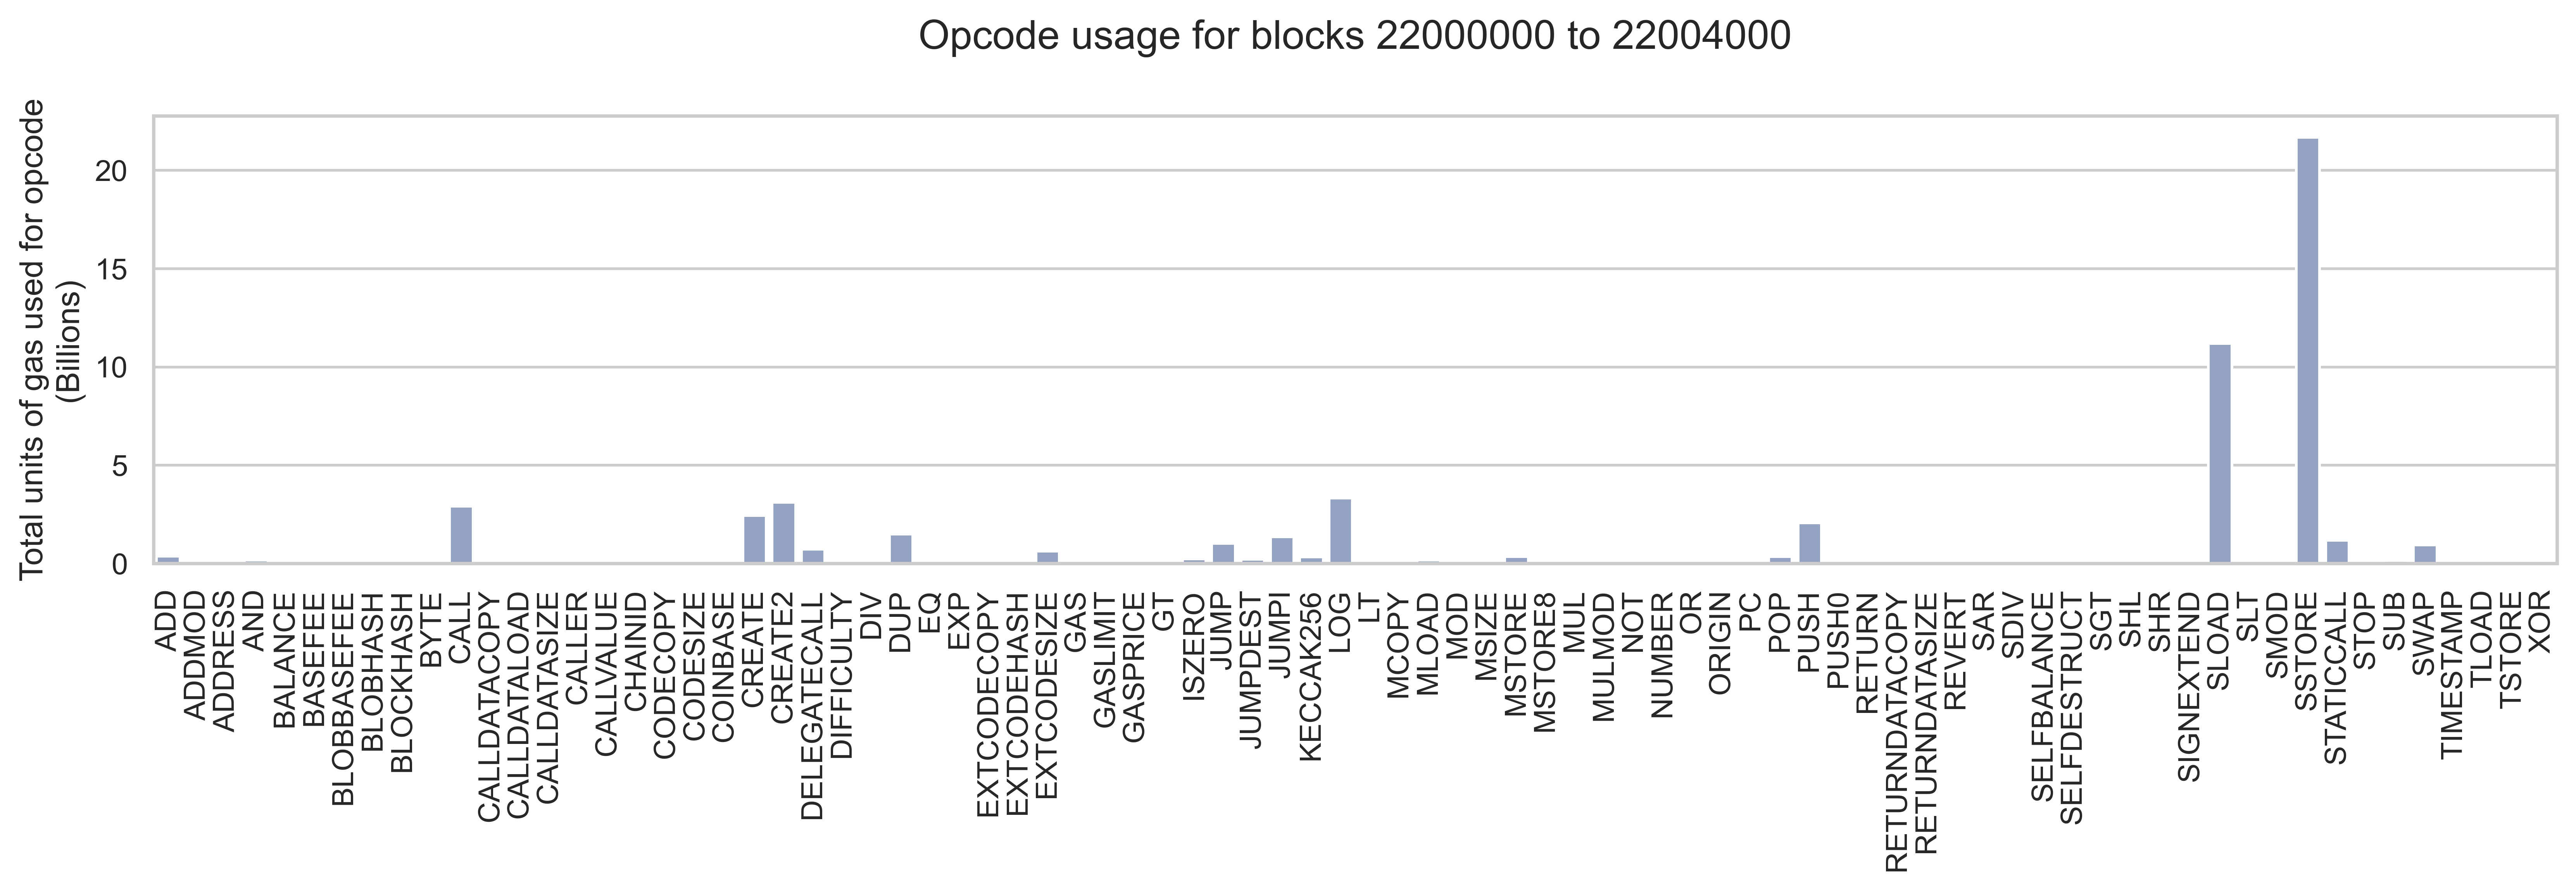

In [43]:
temp_df = filtered_usage_df.groupby("op")["op_total_gas_cost"].sum().reset_index()
temp_df["op_total_gas_cost"] = temp_df["op_total_gas_cost"] / 1_000_000_000
plt.figure(figsize=(16, 3))
sns.barplot(x="op", y="op_total_gas_cost", data=temp_df, color="#8da0cb")
plt.xticks(rotation=90)
plt.title(f"Opcode usage for blocks {block_start} to {block_end}", pad=25)
plt.ylabel("Total units of gas used for opcode\n(Billions)")
plt.xlabel("")
plt.show()

In [44]:
temp_df = (
    filtered_usage_df.groupby("op")["op_total_gas_cost"]
    .sum()
    .reset_index()
    .sort_values("op_total_gas_cost", ascending=False)
    .head(15)
)
temp_df["op_total_gas_cost_perc"] = (
    temp_df["op_total_gas_cost"] / temp_df["op_total_gas_cost"].sum()
)
print(
    temp_df[temp_df["op"].isin(["DELEGATECALL", "STATICCALL", "CALL", "CALLCODE"])][
        "op_total_gas_cost"
    ].sum()
    / temp_df["op_total_gas_cost"].sum()
, "-- call-type cost")
temp_df

0.08831623192021808 -- call-type cost


op  op_total_gas_cost  op_total_gas_cost_perc
73        SSTORE       2.168680e+10                0.398385
70         SLOAD       1.120103e+10                0.205762
40           LOG       3.321844e+09                0.061022
21       CREATE2       3.105889e+09                0.057055
10          CALL       2.907205e+09                0.053405
20        CREATE       2.447651e+09                0.044963
56          PUSH       2.056808e+09                0.037783
25           DUP       1.502971e+09                0.027609
38         JUMPI       1.356268e+09                0.024915
74    STATICCALL       1.172494e+09                0.021539
36          JUMP       1.017015e+09                0.018682
77          SWAP       9.512667e+08                0.017475
22  DELEGATECALL       7.279534e+08                0.013372
30   EXTCODESIZE       6.198456e+08                0.011387
0            ADD       3.617411e+08                0.006645

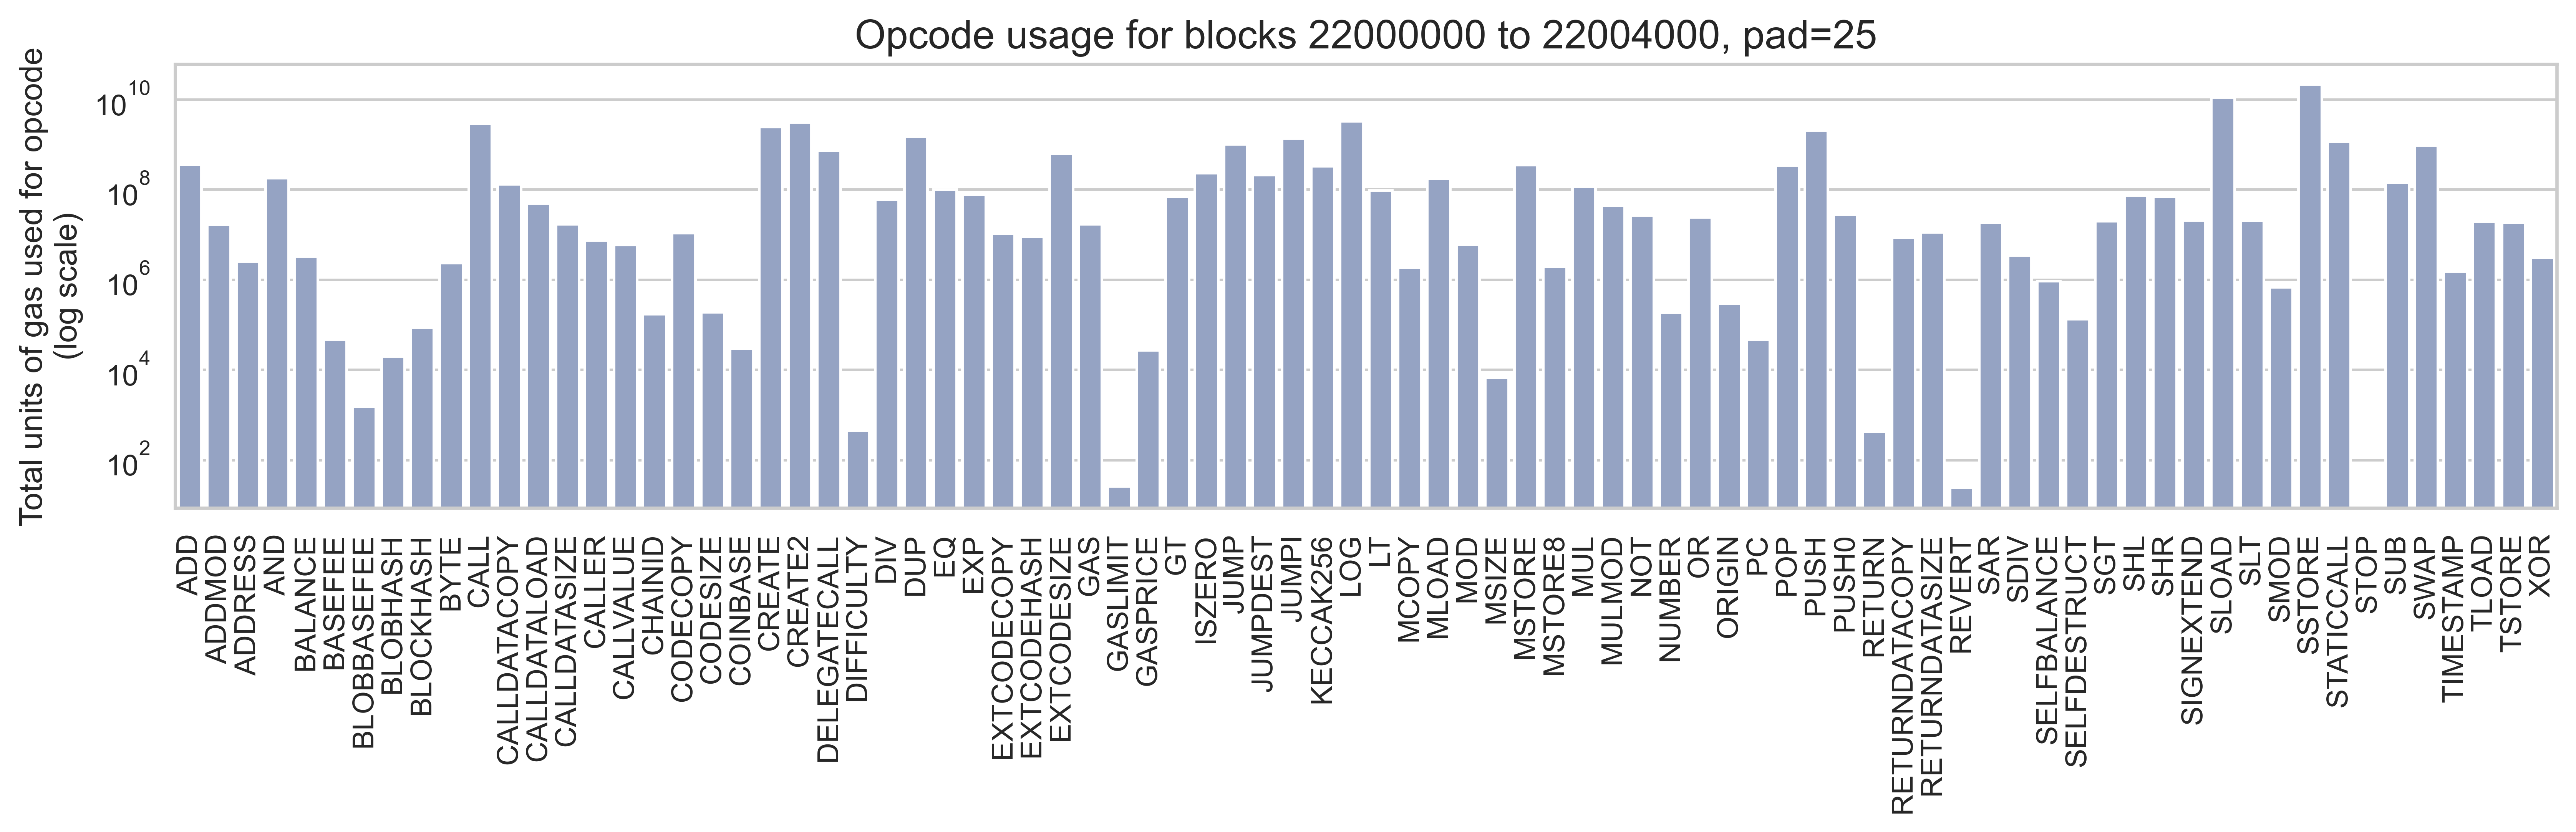

In [45]:
temp_df = filtered_usage_df.groupby("op")["op_total_gas_cost"].sum().reset_index()
temp_df["op_total_gas_cost"] = temp_df["op_total_gas_cost"]
plt.figure(figsize=(16, 3))
sns.barplot(x="op", y="op_total_gas_cost", data=temp_df, color="#8da0cb")
plt.xticks(rotation=90)
plt.yscale("log")
plt.title(f"Opcode usage for blocks {block_start} to {block_end}, pad=25")
plt.ylabel("Total units of gas used for opcode\n(log scale)")
plt.xlabel("")
plt.show()

### Opcode usage correlation

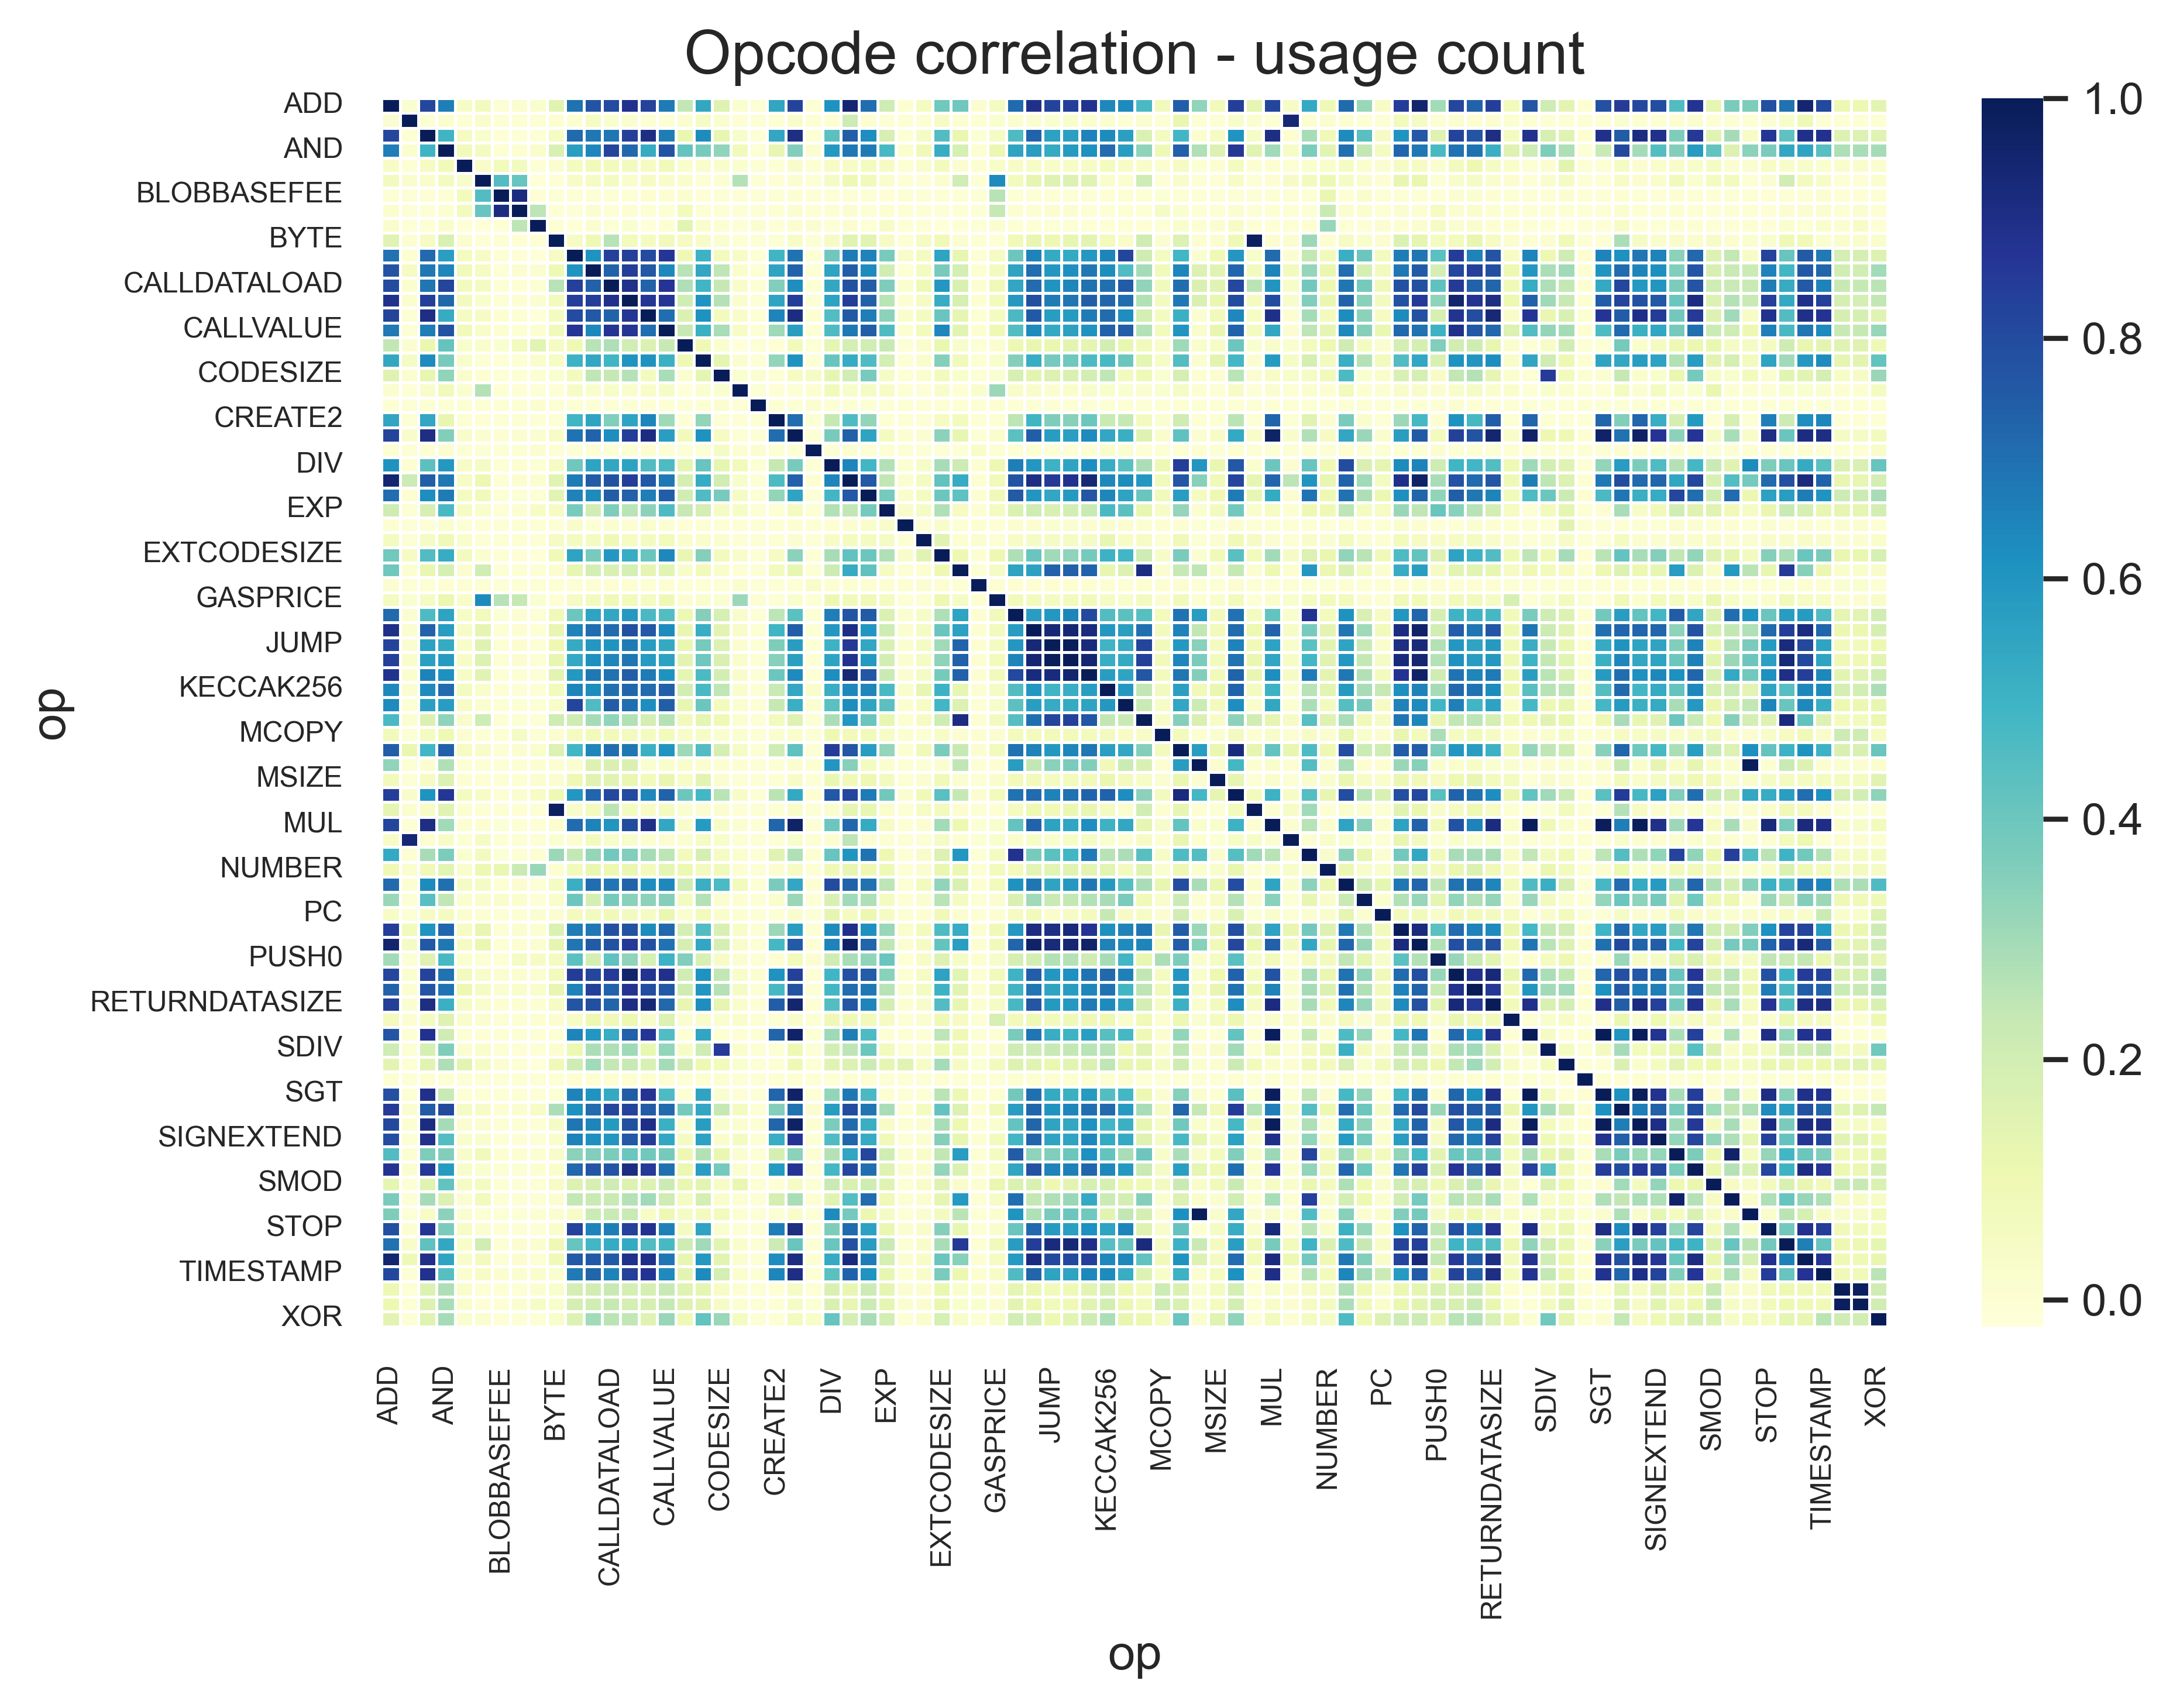

In [46]:
temp_df = pd.pivot_table(
    filtered_usage_df,
    values="op_gas_pair_count",
    index="tx_hash",
    columns="op",
    aggfunc="sum",
    fill_value=0.0,
)
corr_mat = temp_df.corr()
plt.figure(figsize=(8, 6))
ax = sns.heatmap(corr_mat, cmap="YlGnBu", linewidths=0.5)
plt.title("Opcode correlation - usage count")
ax.tick_params(axis="x", labelsize=7)
ax.tick_params(axis="y", labelsize=7)
plt.tight_layout()
plt.show()

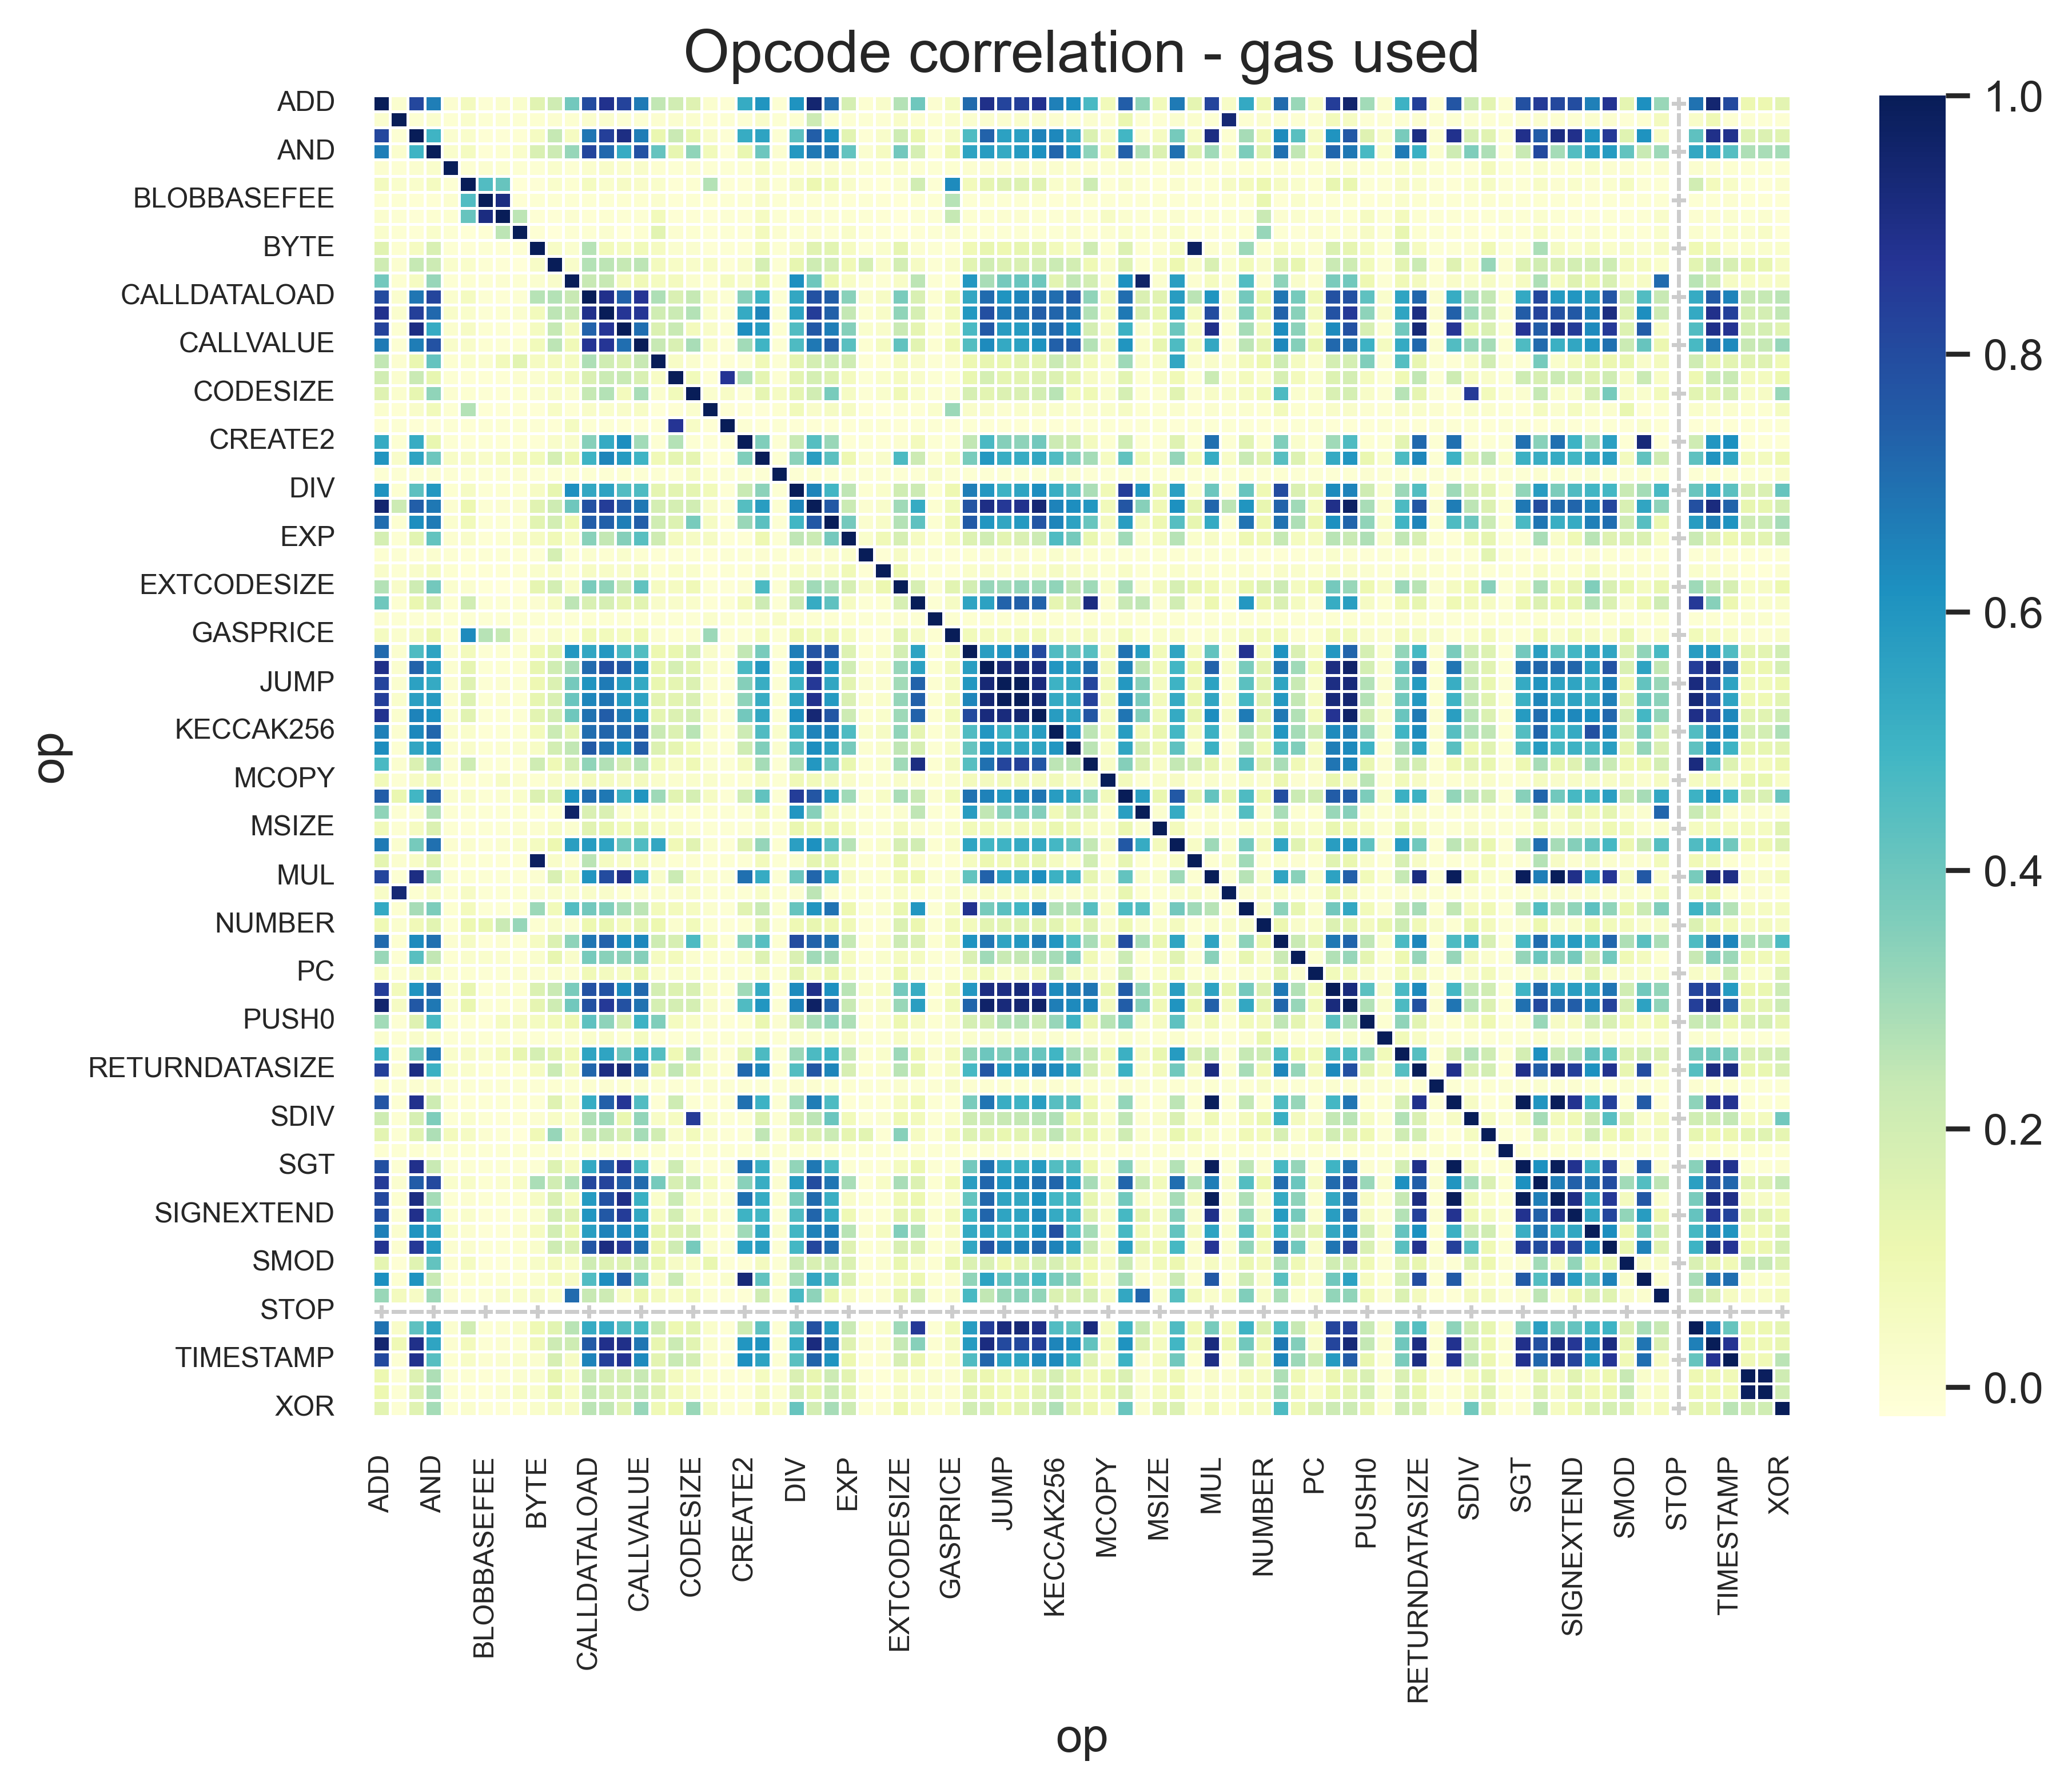

In [47]:
temp_df = pd.pivot_table(
    filtered_usage_df,
    values="op_total_gas_cost",
    index="tx_hash",
    columns="op",
    aggfunc="sum",
    fill_value=0.0,
)
corr_mat = temp_df.corr()
plt.figure(figsize=(8, 6))
ax = sns.heatmap(corr_mat, cmap="YlGnBu", linewidths=0.5)
plt.title("Opcode correlation - gas used")
ax.tick_params(axis="x", labelsize=7)
ax.tick_params(axis="y", labelsize=7)
plt.show()